## Tutoriel : interagir avec le système de stockage S3 du SSP Cloud (MinIO)

In [89]:
! pip install nltk
! pip install datasets
! pip install tiktoken
! pip install spacy

import nltk
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /home/onyxia/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/onyxia/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [92]:
import os

import pandas as pd
import s3fs
import zipfile
import matplotlib.pyplot as plt
from nltk import word_tokenize

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
import tiktoken
import nltk

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay, confusion_matrix
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import VotingClassifier

from spacy.lang.fr.stop_words import STOP_WORDS as fr_stop
from spacy.lang.en.stop_words import STOP_WORDS as en_stop

from itertools import chain

### Récupérer les données d'un challenge

In [93]:
# Create filesystem object
S3_ENDPOINT_URL = "https://" + os.environ["AWS_S3_ENDPOINT"]
fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': S3_ENDPOINT_URL})

# Lister les challenges
#fs.ls("gvimont/diffusion/hackathon-minarm-2024")

# Lister les fichiers d'un challenge
fs.ls("civel/diffusion/hackathon-minarm-2024/AIVSAI")

['civel/diffusion/hackathon-minarm-2024/AIVSAI/.keep',
 'civel/diffusion/hackathon-minarm-2024/AIVSAI/HC3.zip']

In [94]:
# Télécharger les données dans le service
PATH_IN = 'civel/diffusion/hackathon-minarm-2024/AIVSAI/HC3.zip'
fs.download(PATH_IN, 'data/HC3.zip')

# Décompresser les données
with zipfile.ZipFile("data/HC3.zip","r") as zip_file:
    zip_file.extractall("data/")

NB : les données peuvent être également téléchargées directement si besoin, pour être utilisées hors du SSP CLoud.
Exemple pour le fichier ci-dessus (même format de lien pour les autres challenges) : 

http://minio.lab.sspcloud.fr/gvimont/diffusion/hackathon-minarm-2024/AIVSAI/HC3.zip

### Exporter des données

In [166]:
def load_jsonl_files():
    directory = 'data/HC3'

    file_path = "data/HC3/all.jsonl"
    dfs = pd.read_json(file_path, lines=True)

    
    # Get a list of all .jsonl files in the directory, excluding all.jsonl and reddit_eli5.jsonl
    #jsonl_files = [file for file in os.listdir(directory) if file.endswith('.jsonl') and file not in ['all.jsonl']]
    
    # Add data in dataframe
    #dfs = pd.DataFrame()
    #for file in jsonl_files:
    #    file_path = os.path.join(directory, file)
    #    df = pd.read_json(file_path, lines=True)
        
        # Add a new column with the source file name
    #    df['source'] = file[:-6]
        
        # Concatenate to DataFrame
    #    dfs = pd.concat([dfs, df], ignore_index=True)
    
    return dfs

df = load_jsonl_files()
df

,question,human_answers,chatgpt_answers,index,source
0,"Why is every book I hear about a "" NY Times # ...","[Basically there are many categories of "" Best...",[There are many different best seller lists th...,NaN,reddit_eli5
1,"If salt is so bad for cars , why do we use it ...",[salt is good for not dying in car crashes and...,[Salt is used on roads to help melt ice and sn...,NaN,reddit_eli5
2,Why do we still have SD TV channels when HD lo...,[The way it works is that old TV stations got ...,[There are a few reasons why we still have SD ...,NaN,reddit_eli5
3,Why has nobody assassinated Kim Jong - un He i...,[You ca n't just go around assassinating the l...,[It is generally not acceptable or ethical to ...,NaN,reddit_eli5
4,How was airplane technology able to advance so...,[Wanting to kill the shit out of Germans drive...,[After the Wright Brothers made the first powe...,NaN,reddit_eli5
...,...,...,...,...,...
24317,Is rise in pressure from 116/66 to 140/80 norm...,[Hello!Welcome and thank you for asking on HCM...,[It's not uncommon for blood pressure to fluct...,NaN,medicine
24318,What could cause a painless lump in the right ...,"[Hi, * As per my surgical experience, the issu...",[There are several possible causes of a painle...,NaN,medicine
24319,Can Acutret be given to a child for treatment ...,[Although it is difficult to comment whether A...,[It is not appropriate for me to recommend a s...,NaN,medicine
24320,Are BP of 119/65 and pulse of 35 causes for co...,[Welcome and thank you for asking on HCM! I ha...,[It is not uncommon for people with rheumatoid...,NaN,medicine


### Clean questions

In [167]:
def clean_question(question):
    # Remove if question starts with 'Q.'
    return question[3:].strip() if question[:3] == 'Q. ' else question

def clean_questions(df):
    df_cleaned = df.copy()
    
    df_cleaned['question'] = df_cleaned['question'].apply(lambda x: clean_question(x))
    
    return df_cleaned

### Clean Answers

In [168]:
def clean_answer(answer):
    # Transform list answer into string
    return ' '.join(answer) if isinstance(answer, list) else answer

def clean_answers(df):
    df_cleaned = df.copy()
    
    df_cleaned['human_answers'] = df_cleaned['human_answers'].apply(lambda x: clean_answer(x))
    df_cleaned['chatgpt_answers'] = df_cleaned['chatgpt_answers'].apply(lambda x: clean_answer(x))
    
    return df_cleaned

In [169]:
def clean_type_data(df) :
    
    df_cleaned = df.copy()
    df_cleaned['human_answers'].astype(str)
    df_cleaned['chatgpt_answers'].astype(str)
    
    return df_cleaned

### Clean Dataframe

In [198]:
def clean_dataframe(df):
    df = clean_answers(df)
    df = df.drop_duplicates()
    df = clean_questions(df)
    df = clean_type_data(df)
    if 'index' in df.columns :
        df = df.drop(columns="index")
    df = df.dropna()
    
    return df

In [199]:
df = clean_dataframe(df)
df

,question,human_answers,chatgpt_answers,source
0,"Why is every book I hear about a "" NY Times # ...","Basically there are many categories of "" Best ...",There are many different best seller lists tha...,reddit_eli5
1,"If salt is so bad for cars , why do we use it ...",salt is good for not dying in car crashes and ...,Salt is used on roads to help melt ice and sno...,reddit_eli5
2,Why do we still have SD TV channels when HD lo...,The way it works is that old TV stations got a...,There are a few reasons why we still have SD (...,reddit_eli5
3,Why has nobody assassinated Kim Jong - un He i...,You ca n't just go around assassinating the le...,It is generally not acceptable or ethical to a...,reddit_eli5
4,How was airplane technology able to advance so...,Wanting to kill the shit out of Germans drives...,After the Wright Brothers made the first power...,reddit_eli5
...,...,...,...,...
24317,Is rise in pressure from 116/66 to 140/80 norm...,Hello!Welcome and thank you for asking on HCM!...,It's not uncommon for blood pressure to fluctu...,medicine
24318,What could cause a painless lump in the right ...,"Hi, * As per my surgical experience, the issue...",There are several possible causes of a painles...,medicine
24319,Can Acutret be given to a child for treatment ...,Although it is difficult to comment whether Ac...,It is not appropriate for me to recommend a sp...,medicine
24320,Are BP of 119/65 and pulse of 35 causes for co...,Welcome and thank you for asking on HCM! I hav...,It is not uncommon for people with rheumatoid ...,medicine


In [200]:
# Export vers un bucket personnel
PATH_OUT = 'misterfacile/diffusion/projet-mongroupe-hackathon/all_dataset.csv'
with fs.open(PATH_OUT, 'w') as file_out:
    df.to_csv(file_out, index=False)

In [173]:
# NB : le dossier 'diffusion' permet un accès en lecture à tous les membres du groupe !
# Tous les membres peuvent donc le voir et l'utiliser dans un service
fs.ls("misterfacile/diffusion/projet-mongroupe-hackathon")

['misterfacile/diffusion/projet-mongroupe-hackathon/all_dataset.csv',
 'misterfacile/diffusion/projet-mongroupe-hackathon/medicine.csv']

In [201]:
with fs.open(PATH_OUT, mode="r") as file_in:
    df_test = pd.read_csv(file_in)
    df_test = clean_dataframe(df_test)

In [202]:
df_test.head()

,question,human_answers,chatgpt_answers,source
0,"Why is every book I hear about a "" NY Times # ...","Basically there are many categories of "" Best ...",There are many different best seller lists tha...,reddit_eli5
1,"If salt is so bad for cars , why do we use it ...",salt is good for not dying in car crashes and ...,Salt is used on roads to help melt ice and sno...,reddit_eli5
2,Why do we still have SD TV channels when HD lo...,The way it works is that old TV stations got a...,There are a few reasons why we still have SD (...,reddit_eli5
3,Why has nobody assassinated Kim Jong - un He i...,You ca n't just go around assassinating the le...,It is generally not acceptable or ethical to a...,reddit_eli5
4,How was airplane technology able to advance so...,Wanting to kill the shit out of Germans drives...,After the Wright Brothers made the first power...,reddit_eli5


# Tokenizer

In [203]:
whole_doc = " ".join(df_test['human_answers'].head())
whole_doc

'Basically there are many categories of " Best Seller " . Replace " Best Seller " by something like " Oscars " and every " best seller " book is basically an " oscar - winning " book . May not have won the " Best film " , but even if you won the best director or best script , you \'re still an " oscar - winning " film . Same thing for best sellers . Also , IIRC the rankings change every week or something like that . Some you might not be best seller one week , but you may be the next week . I guess even if you do n\'t stay there for long , you still achieved the status . Hence , # 1 best seller . If you \'re hearing about it , it \'s because it was a very good or very well - publicized book ( or both ) , and almost every good or well - publicized book will be # 1 on the NY Times bestseller list for at least a little bit . Kindof like how almost every big or good movies are # 1 at the box office on their opening weekend . One reason is lots of catagories . However , how the NY Times cal

In [204]:
def nltk_tokenize(doc: str) -> list[str]:
    return word_tokenize(doc)

def gpt_tokenize(doc: str) -> list:
    enc = tiktoken.encoding_for_model("gpt-4")
    tokens = enc.encode(doc)
    return [str(token) for token in tokens]

In [205]:
def tokenize(doc: str, base_tokenizer=word_tokenize, do_lower=False, do_remove_stop_word=False, custom_stop_words=[], do_lemmatize=False) -> tuple[list,list]:
    if do_lower:
        doc = doc.lower()
    list_token = base_tokenizer(doc)

    if do_remove_stop_word:
        stop_words = en_stop | set("-.!?()_;:,'") | {'...'} | set(custom_stop_words) 
        list_token = [token for token in list_token if token not in stop_words]
        
    if do_lemmatize:
        wnl = WordNetLemmatizer()
        list_token = [wnl.lemmatize(t) for t in list_token]

    return list_token

def use_tokenizer(tokenizer, base_tokenizer=word_tokenize):
    return tokenizer

def remove_stop_words(custom_stop_words):
    return custom_stop_words

def add_stop_words(words, custom_stop_words):
    custom_stop_words.extend(words)
    return custom_stop_words

def lower():
    return True

def lemmatize():
    return True

In [206]:
custom_stop_words = []
list_token = tokenize(whole_doc, do_lower=True, do_remove_stop_word=True, custom_stop_words=custom_stop_words)
vocab = set(list_token)

In [207]:
occ = { token : list_token.count(token) for token in vocab }
sorted(occ.items(), key = lambda x : x[1], reverse=True)[:10]

[('salt', 15),
 ('sd', 15),
 ('``', 14),
 ('best', 10),
 ('hd', 10),
 ('stations', 9),
 ('old', 8),
 ('channels', 8),
 ('like', 8),
 ('good', 7)]

In [208]:
df_test.head()

,question,human_answers,chatgpt_answers,source
0,"Why is every book I hear about a "" NY Times # ...","Basically there are many categories of "" Best ...",There are many different best seller lists tha...,reddit_eli5
1,"If salt is so bad for cars , why do we use it ...",salt is good for not dying in car crashes and ...,Salt is used on roads to help melt ice and sno...,reddit_eli5
2,Why do we still have SD TV channels when HD lo...,The way it works is that old TV stations got a...,There are a few reasons why we still have SD (...,reddit_eli5
3,Why has nobody assassinated Kim Jong - un He i...,You ca n't just go around assassinating the le...,It is generally not acceptable or ethical to a...,reddit_eli5
4,How was airplane technology able to advance so...,Wanting to kill the shit out of Germans drives...,After the Wright Brothers made the first power...,reddit_eli5


# Compare the length of the answer between human and ChatGPT

In [218]:
def compareLengthAnswer(data, category="") :

    #Collect the length of the answer
    if (category == "") :
        lengthHumanAnswer = data['human_answers'].apply(len)
        lengthChatGPTAnswer = data['chatgpt_answers'].apply(len)
    else :
        lengthHumanAnswer = data[data['source'] == category]['human_answers'].apply(len)
        lengthChatGPTAnswer = data[data['source'] == category]['chatgpt_answers'].apply(len)
    
    # Display the graphic
    plt.figure(figsize=(10, 6))
    plt.hist(lengthHumanAnswer, bins=20, alpha=0.5, label='Human Answers')
    plt.hist(lengthChatGPTAnswer, bins=20, alpha=0.5, label='ChatGPT Answers')
    plt.title('Comparaison de la taille des réponses')
    plt.xlabel('Quantité de caractères par réponse')
    plt.ylabel('Quantité de réponse')
    plt.legend()
    plt.grid(True)
    plt.show()

23361


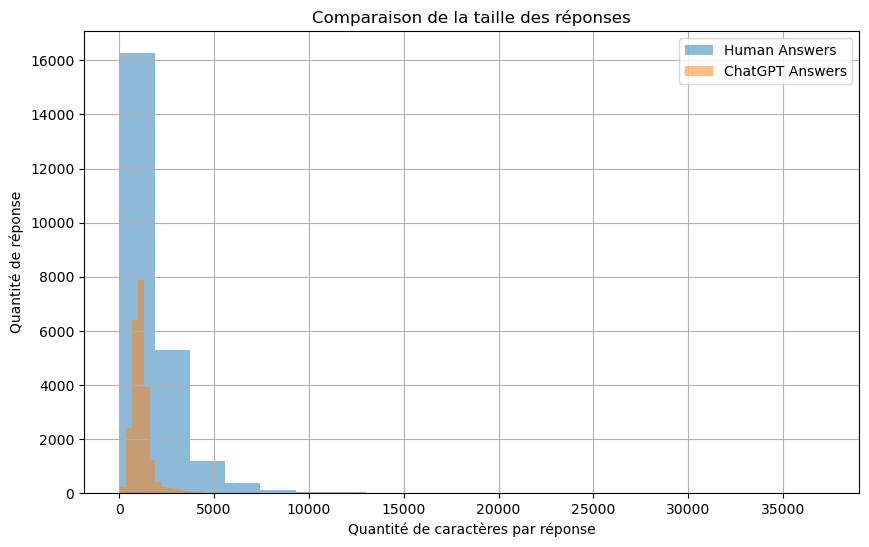

In [217]:
compareLengthAnswer(df_test)

In [144]:
df_wiki = df_test[df_test['source'] == 'wiki_csai']['human_answers']


In [145]:
df_test.head()

,question,human_answers,chatgpt_answers,source
0,"Why is every book I hear about a "" NY Times # ...","Basically there are many categories of "" Best ...",There are many different best seller lists tha...,reddit_eli5
1,"If salt is so bad for cars , why do we use it ...",salt is good for not dying in car crashes and ...,Salt is used on roads to help melt ice and sno...,reddit_eli5
2,Why do we still have SD TV channels when HD lo...,The way it works is that old TV stations got a...,There are a few reasons why we still have SD (...,reddit_eli5
3,Why has nobody assassinated Kim Jong - un He i...,You ca n't just go around assassinating the le...,It is generally not acceptable or ethical to a...,reddit_eli5
4,How was airplane technology able to advance so...,Wanting to kill the shit out of Germans drives...,After the Wright Brothers made the first power...,reddit_eli5
